<h1>Exploring the limit order book data</h1>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg

In [2]:
df = pd.read_csv("../../raw/processed/msft.csv")
df["mid_price"] = (df["bid_price"] + df["offer_price"]) / 2
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by="timestamp")

FileNotFoundError: [Errno 2] No such file or directory: '../../raw/processed/msft.csv'

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df["timestamp"], df["mid_price"])
plt.title("Mid price for MSFT")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

NameError: name 'df' is not defined

<Figure size 1000x600 with 0 Axes>

<h3>Autocorrelation</h3>

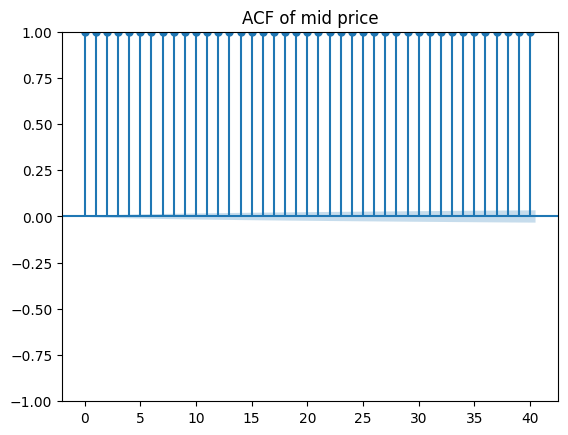

In [ ]:
# should ensure regular sampling when using acf
plot_acf(df["mid_price"], lags=40) 
plt.title("ACF of mid price")
plt.show()

<h3>Analysis of timediffs</h3>

In [ ]:
time_diffs = df["timestamp"] - df["timestamp"].shift()
time_diffs = pd.to_timedelta(time_diffs)
time_diffs = time_diffs.dt.total_seconds()

time_diffs_windsorized = time_diffs.copy()
quantile_90 = time_diffs.quantile(0.9)
time_diffs_windsorized.loc[time_diffs_windsorized >= quantile_90] = quantile_90

In [ ]:
print(time_diffs.describe())
print(time_diffs_windsorized.describe())
print(f'Kurtosis: {time_diffs.kurtosis()}')

count    273430.000000
mean          0.085579
std           0.191965
min           0.001000
25%           0.001000
50%           0.012000
75%           0.084000
max           7.556000
Name: timestamp, dtype: float64
count    273430.000000
mean          0.057866
std           0.081576
min           0.001000
25%           0.001000
50%           0.012000
75%           0.084000
max           0.245000
Name: timestamp, dtype: float64
Kurtosis: 78.13309443823887


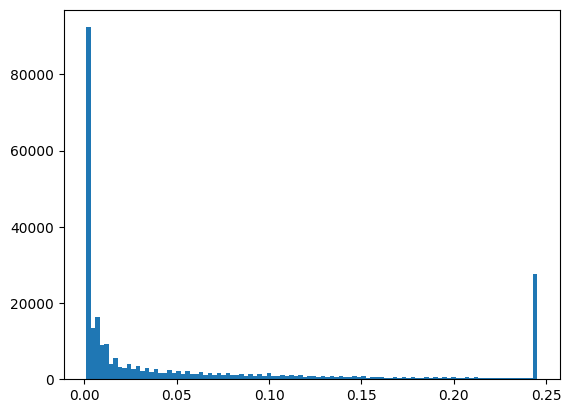

In [ ]:
plt.hist(time_diffs_windsorized, bins=100)
plt.show()

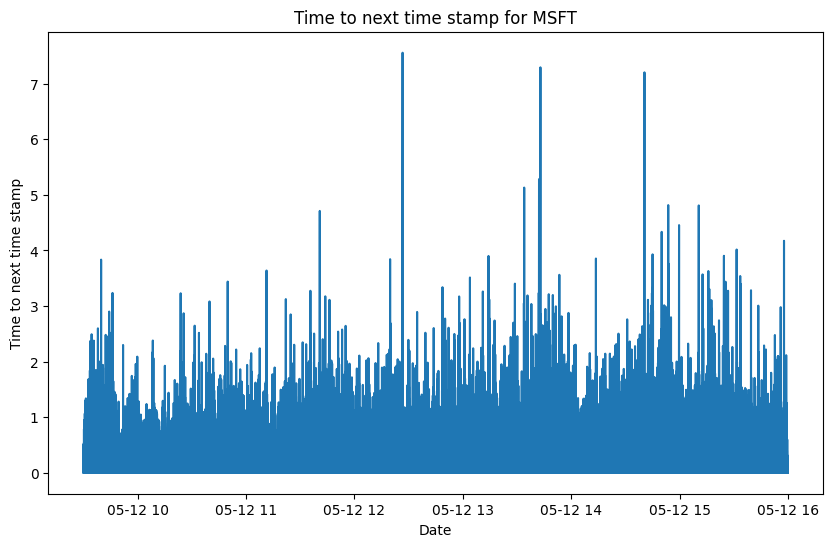

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df["timestamp"], time_diffs)
plt.xlabel("Date")
plt.ylabel("Time to next time stamp")
plt.title("Time to next time stamp for MSFT")
plt.show()

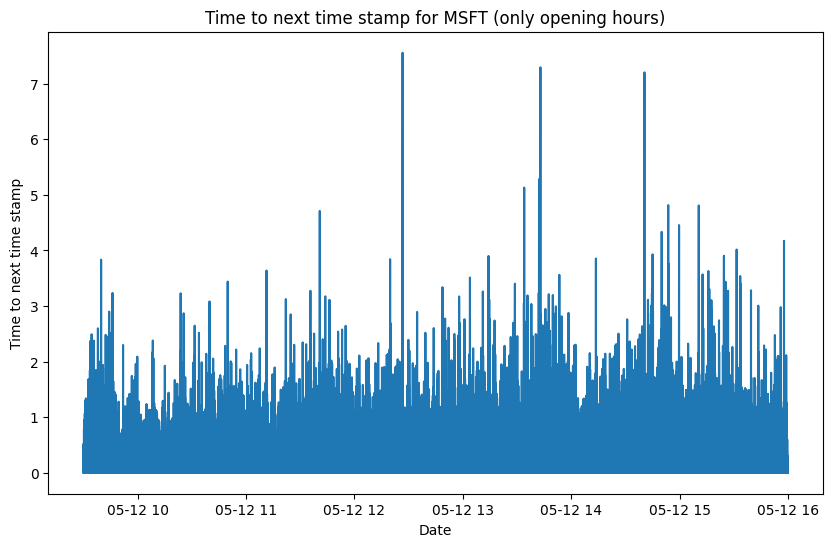

In [ ]:
opening_market_idx = df.loc[(df.loc[:, "timestamp"].dt.time > pd.to_datetime("9:30").time()) & 
                            (df.loc[:, "timestamp"].dt.time < pd.to_datetime("16:00").time()), :].index

plt.figure(figsize=(10, 6))
plt.plot(df.loc[opening_market_idx, "timestamp"], time_diffs.loc[opening_market_idx])
plt.xlabel("Date")
plt.ylabel("Time to next time stamp")
plt.title("Time to next time stamp for MSFT (only opening hours)")
plt.show()

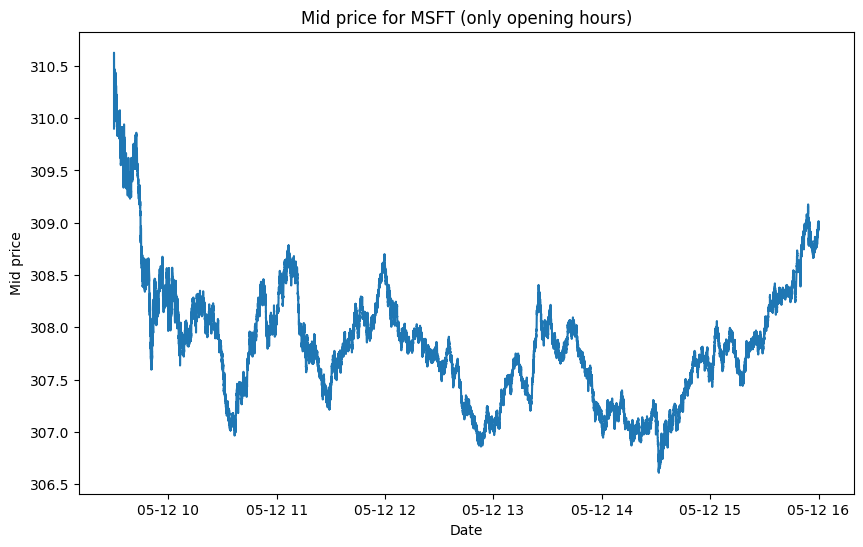

In [ ]:
opening_market_idx = df.loc[(df.loc[:, "timestamp"].dt.time > pd.to_datetime("9:30").time()) & 
                            (df.loc[:, "timestamp"].dt.time < pd.to_datetime("16:00").time()), :].index

plt.figure(figsize=(10, 6))
plt.plot(df.loc[opening_market_idx, "timestamp"], df.loc[opening_market_idx, "mid_price"])
plt.xlabel("Date")
plt.ylabel("Mid price")
plt.title("Mid price for MSFT (only opening hours)")
plt.show()

                            AutoReg Model Results                             
Dep. Variable:              mid_price   No. Observations:               273431
Model:                     AutoReg(5)   Log Likelihood             1046727.034
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Tue, 29 Oct 2024   AIC                       -2093440.069
Time:                        09:36:34   BIC                       -2093366.437
Sample:                             5   HQIC                      -2093418.687
                               273431                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0203      0.005      3.900      0.000       0.010       0.031
mid_price.L1     1.0036      0.002    526.592      0.000       1.000       1.007
mid_price.L2     0.0118      0.003      4.38

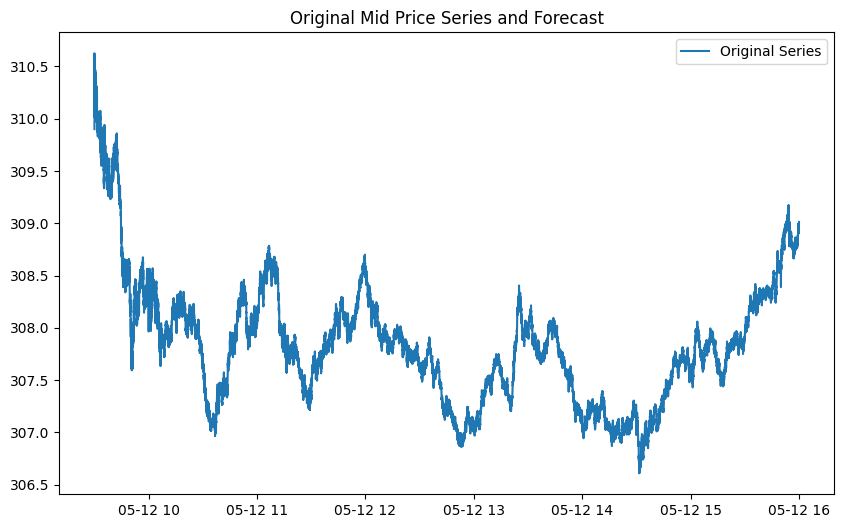

In [ ]:
model = AutoReg(df["mid_price"], lags=5).fit()
print(model.summary())

forecast = model.predict(start=len(df["mid_price"]), end=len(df["mid_price"]) + 9)
print("Forecasted Values:", forecast)

# Plotting the original series and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df["timestamp"], df["mid_price"], label='Original Series')
# plt.plot(range(len(df["mid_price"]), len(df["mid_price"]) + 10), forecast, label='Forecast', color='red')
plt.legend()
plt.title("Original Mid Price Series and Forecast")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

def optimal_lag_selection(data, max_lags=20, criterion="AIC"):
    """
    Find the optimal number of lags for an AR model based on AIC or BIC.
    
    Parameters:
        data (array-like): The time series data.
        max_lags (int): Maximum number of lags to test.
        criterion (str): Criterion to minimize, either "AIC" or "BIC".
    
    Returns:
        int: Optimal number of lags for the AR model.
        pd.DataFrame: DataFrame with lag, AIC, and BIC values.
    """
    # Initialize lists to store results
    aic_values = []
    bic_values = []
    lags = range(1, max_lags + 1)
    
    # Fit AR models for each lag
    for p in lags:
        try:
            model = AutoReg(data, lags=p).fit()
            aic_values.append(model.aic)
            bic_values.append(model.bic)
        except ValueError:
            # Some lag values may be too large for the data, skip these
            continue
    
    # Compile results into DataFrame
    results = pd.DataFrame({"Lag": lags, "AIC": aic_values, "BIC": bic_values})
    
    # Find the optimal lag based on the selected criterion
    if criterion == "AIC":
        optimal_lag = results.loc[results["AIC"].idxmin(), "Lag"]
    elif criterion == "BIC":
        optimal_lag = results.loc[results["BIC"].idxmin(), "Lag"]
    else:
        raise ValueError("Criterion must be either 'AIC' or 'BIC'")
    
    return optimal_lag, results

# Example usage
data = pd.read_csv("../../data/processed/msft.csv")["mid_price"]
optimal_lag, results_df = optimal_lag_selection(data, max_lags=20, criterion="AIC")
print("Optimal lag:", optimal_lag)
print(results_df)


Optimal lag: 20
    Lag           AIC           BIC
0     1 -2.089138e+06 -2.089106e+06
1     2 -2.091455e+06 -2.091413e+06
2     3 -2.091511e+06 -2.091458e+06
3     4 -2.091564e+06 -2.091501e+06
4     5 -2.093440e+06 -2.093366e+06
5     6 -2.093450e+06 -2.093366e+06
6     7 -2.094323e+06 -2.094229e+06
7     8 -2.094316e+06 -2.094210e+06
8     9 -2.094309e+06 -2.094193e+06
9    10 -2.094302e+06 -2.094176e+06
10   11 -2.094511e+06 -2.094375e+06
11   12 -2.095626e+06 -2.095478e+06
12   13 -2.095627e+06 -2.095469e+06
13   14 -2.095644e+06 -2.095476e+06
14   15 -2.095887e+06 -2.095708e+06
15   16 -2.095920e+06 -2.095730e+06
16   17 -2.096007e+06 -2.095807e+06
17   18 -2.095997e+06 -2.095787e+06
18   19 -2.096059e+06 -2.095839e+06
19   20 -2.096224e+06 -2.095993e+06


In [ ]:
df = pd.read_csv("../../data/processed/tq_data_gridded/df_tot_gridded.csv")

In [ ]:
df["sip_timestamp"] = pd.to_datetime(df["sip_timestamp"])
date = "2024-09-03"

(46800, 9)


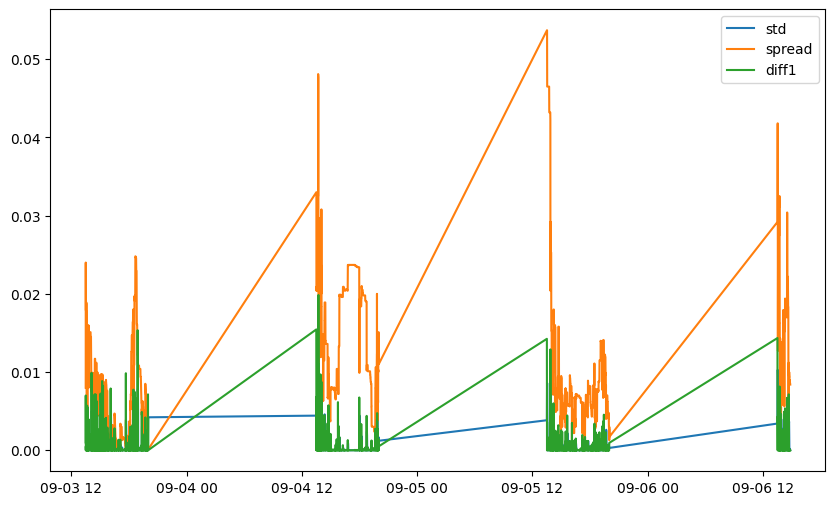

In [ ]:
ticker = "EAF"
ticker_data = df[(df["ticker"] == ticker)]
print(ticker_data.shape)
ticker_data = ticker_data.iloc[:7500, :]
ticker_data = ticker_data.set_index(ticker_data["sip_timestamp"])
s1 = ticker_data["mid_price"].rolling(20).std()
s2 = ticker_data["ask_price"] - ticker_data["bid_price"]
s3 = ticker_data["mid_price"].diff(1).abs()
plt.figure(figsize=(10, 6))
plt.plot(s1, label="std")
plt.plot(s2, label="spread")
plt.plot(s3, label="diff1")
plt.legend()
plt.show()


In [11]:
df = pd.read_csv("../../data/processed/tq_data_gridded/df_tot_gridded.csv")
ticker = "EAF"
ticker_data = df[df["ticker"] == ticker].copy()

In [12]:
weights = ticker_data["bid_size"] / (ticker_data["ask_size"] + ticker_data["bid_size"])
ticker_data["weighted_mid"] = ticker_data["bid_price"]*(1-weights) + ticker_data["ask_price"]*weights
ticker_data = ticker_data.set_index(pd.to_datetime(ticker_data["sip_timestamp"]))

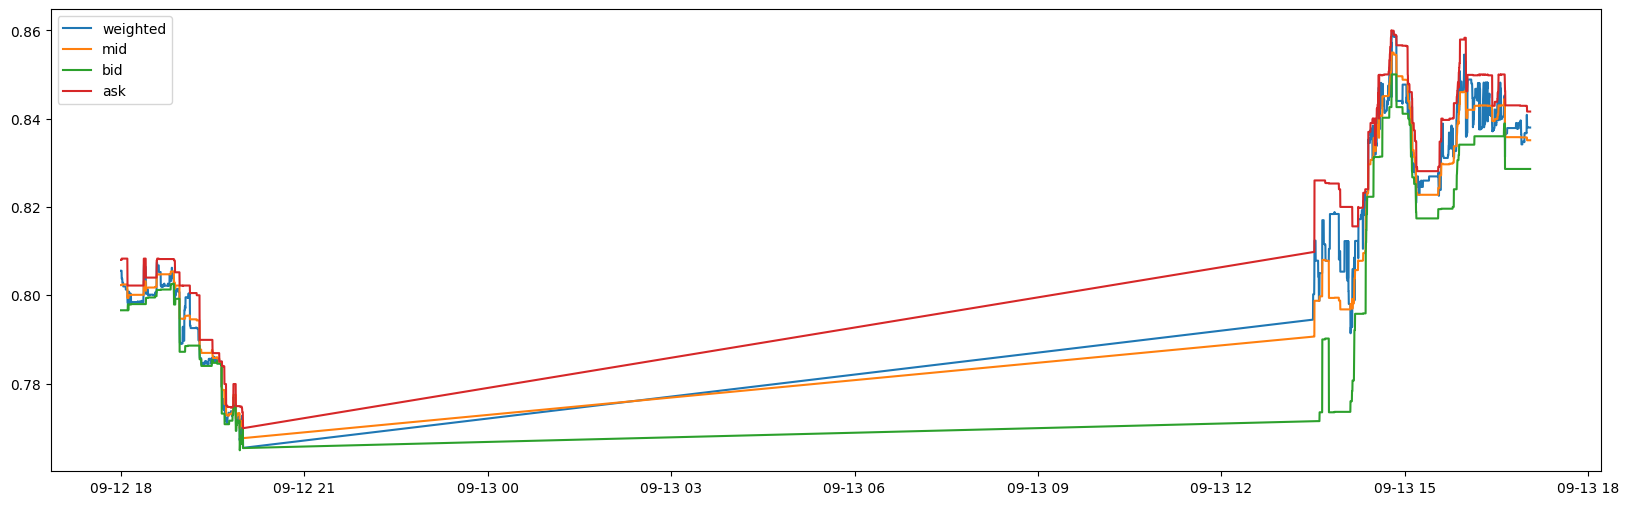

In [27]:
plt.figure(figsize=(20, 6))
plt.plot(ticker_data["weighted_mid"].iloc[18000:20000], label="weighted")
plt.plot(ticker_data["mid_price"].iloc[18000:20000], label="mid")
plt.plot(ticker_data["bid_price"].iloc[18000:20000], label="bid")
plt.plot(ticker_data["ask_price"].iloc[18000:20000], label="ask")
plt.legend()
plt.show()

0.7278722342950477


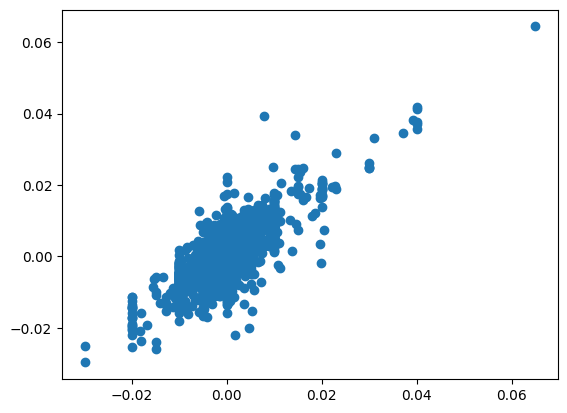

In [20]:
print(np.corrcoef(ticker_data["mid_price"].diff(1).dropna(), ticker_data["weighted_mid"].diff(1).dropna())[0,1])
plt.scatter(ticker_data["mid_price"].diff(1), ticker_data["weighted_mid"].diff(1))
plt.show()